# Predictive models applied to forecast energy needs in buildings

Author : Charles Gaydon

Started : 29/10/2017

Last Edited : 2/11/2017

In [183]:
import numpy as np 
import pandas as pd
import sklearn as sk
from sklearn.neural_network import MLPRegressor


All_X_train = pd.read_csv("./train_set_X.csv",sep=';')
All_Y_train = pd.read_csv("./train_set_Y.csv",sep=';')

# Bat 3 lacks a few data point during a short period of time. 
# We hence get rid of the rows concerned.
All_X_train = All_X_train[(All_X_train['x1'] != 0) & (All_X_train['x2'] != 0) & 
                        (All_X_train['x3'] != 0) & (All_X_train['x4'] != 0) & 
                        (All_X_train['x5'] != 0)].dropna()
All_Y_train = All_Y_train[All_Y_train['Id'].isin(All_X_train['Id'])]
print(All_X_train.shape, All_Y_train.shape)
All_X_train["Time"] = All_X_train.apply(lambda x : int(x[2].split()[1][0:2]),axis=1)
print('X :')
print(All_X_train.head(3))
print('Y :')
print(All_Y_train.head(3))

#we split our data set
train_size = int(0.999*All_X_train.shape[0])

X_train = All_X_train.iloc[0:train_size]
Y_train = All_Y_train.iloc[0:train_size]

X_val = All_X_train.iloc[train_size:]
Y_val = All_Y_train.iloc[train_size:]

(11369, 8) (11369, 6)
X :
   Id  Id_bat  Time   x1   x2    x3       x4     x5
0   0       1     0  1.5  8.1  22.0  380.183   20.0
1   1       1     1  1.6  8.2  21.9  378.100  120.0
2   2       1     2  1.4  7.9  21.9  374.983  120.0
Y :
   Id     y1    y2   y3  y4     y5
0   0  110.5  40.9  0.0  48  13.94
1   1  110.8  38.6  0.0  48  20.91
2   2  112.6  37.0  0.0  48  20.91


Using Tableau, we saw that we have to predict : 

- Y1, Y2, Y4, Y5 for Bat 1, Bat 2 and Bat 4 ;
- Y1, Y3 and Y5 for Bat 3.

Hence we will use to train :
Bat 1,2,3,4 for Y1, Y5 ;
Bat 1,2,4 for Y2, Y4 ;
Bat 3 for Y3

In [184]:
X_train_15 = X_train[X_train['Id_bat'].isin([1,2,3,4])].copy()
Y_train_15 = Y_train[X_train['Id_bat'].isin([1,2,3,4])][["y1","y5"]].copy()

X_train_24 = X_train[X_train['Id_bat'].isin([1,2,4])].copy()
Y_train_24 = Y_train[X_train['Id_bat'].isin([1,2,4])][["y2","y4"]].copy()

X_train_3 = X_train[X_train['Id_bat'].isin([3])].copy()
Y_train_3 = Y_train[X_train['Id_bat'].isin([3])][["y3"]].copy()

In [197]:
from sklearn.ensemble import RandomForestRegressor
def give_me_a_model(style = "MLP"):
    if style == "MLP":
        m = MLPRegressor((150,150,150,150),solver ='lbfgs',
            batch_size = 200,max_iter = 100, verbose = True, early_stopping =False)
    elif style == "RF" :
        m = RandomForestRegressor(n_estimators = 300,n_jobs = 20, verbose=0)
    return(m)

In [198]:
style = "RF"
m15 = give_me_a_model(style)
m24 = give_me_a_model(style)
m3 = give_me_a_model(style)

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    1.2s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    2.1s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Do

[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    3.9s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    6.7s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Do

[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    5.3s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.0s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    7.0s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Do

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    5.1s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Do

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    2.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    3.7s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    3.0s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    5.1s finished
[Parallel(n_jobs=20)]: Do

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    1.3s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    2.3s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    2.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    3.7s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Do

[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    1.4s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    2.3s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Do

[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    6.8s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.3s finished


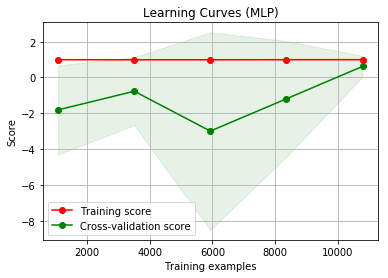

In [196]:
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

title = "Learning Curves (MLP)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
#cv = ShuffleSplit(n_splits=20, test_size=0.1, random_state=0)
cv = 20
plot_learning_curve(m15, title, X_train_15, Y_train_15, cv=cv)
title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
plt.show()


In [ ]:
plot_learning_curve(m24, title, X_train_24, Y_train_24, cv=cv)
title = "Learning Curves)"
plt.show()


In [ ]:
plot_learning_curve(m3, title, X_train_3, Y_train_3, cv=cv)
title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
plt.show()

In [187]:
m15.fit(X_train_15,Y_train_15)
m24.fit(X_train_24,Y_train_24)
m3.fit(X_train_3,Y_train_3)

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.0s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    7.2s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    3.0s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    5.2s finished
/home/cgaydon/Ressources/anaconda3/envs/KaggleML/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    1.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=20,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [188]:
def score_function(y_true, y_pred):
    s = np.sum((y_pred.values[:,1:] - y_true.values[:,1:])**2)/y_pred.shape[0]
    s = np.sum(s)
    return(s)

def do_a_prediction(X_dataset,target_Y = None) :

    ## Testing : 
    imp = sk.preprocessing.Imputer() #few Nan value in x4
    X_dataset = imp.fit_transform(X_dataset).copy()
    X_dataset = pd.DataFrame(X_dataset,columns = X_train.columns.tolist())

    #prediction
    y15 = m15.predict(X_dataset)
    y24 = m24.predict(X_dataset)
    y3 = m3.predict(X_dataset)

    #We put the value 0 where NA belongs
    y24[X_dataset['Id_bat'].isin([3])] = 0
    y3[X_dataset['Id_bat'].isin([1,2,4])] = 0

    #We merge the results :
    t = np.stack((X_dataset.values[:,0],y15[:,0],y24[:,0],y3,y24[:,1],y15[:,1]),axis=-1)
    y = pd.DataFrame(t,
        columns = ['Id','y1','y2','y3','y4','y5'])
    print(y.head(5))
    
    if target_Y is not None :
        score = score_function(y,target_Y)
        print("Final score is : " + str(score))
        
    return(y)


We test the results.

In [189]:
y_val_predicted = do_a_prediction(X_val,target_Y = Y_val)

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.0s finished


        Id          y1          y2   y3          y4        y5
0  11696.0  102.884333  192.825020  0.0  160.226667  0.033333
1  11697.0  102.770333  192.154003  0.0  160.186667  0.133333
2  11698.0  102.677000  191.938010  0.0  161.400000  0.100000
3  11699.0  103.272000  190.414263  0.0  160.053333  0.166667
4  11700.0  103.278000  189.371477  0.0  158.026667  0.200000
Final score is : 143.183063223


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished


We generate the prediction for the test set and save the result, before uploading it to the competition's website.

In [190]:
X_test = pd.read_csv("test_set_X.csv",sep=';')
X_test["Time"] = X_test.apply(lambda x : int(x[2].split()[1][0:2]),axis=1)
y_test = do_a_prediction(X_test,target_Y = None)

y_test.to_csv(path_or_buf='RF300.csv',sep=';',header = True, index=False)

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished


        Id         y1          y2   y3          y4         y5
0  11708.0  56.808667  227.404467  0.0  100.960000  50.366667
1  11709.0  56.744667  225.126667  0.0  100.720000  64.033333
2  11710.0  56.754000  224.949707  0.0  100.880000  63.100000
3  11711.0  56.662333  225.428310  0.0  100.266667  67.400000
4  11712.0  56.562667  222.157337  0.0   99.360000  69.933333


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished
